In [1]:
%matplotlib inline

In [2]:
import os
import gym
import gym_game
import pygame
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import pkg_resources
import time
import matplotlib.pyplot as plt


# pkg_resources.get_distribution("gym").version

In [3]:
from gym.wrappers.human_rendering import HumanRendering
from gym.envs.toy_text.frozen_lake import generate_random_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("GridWorld-v0", render_mode="rgb_array").unwrapped

wrapped = HumanRendering(env)
wrapped.reset()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(10, interpolation=Image.CUBIC),
                    T.ToTensor()])

device

C:\Users\xande\AppData\Local\Temp\ipykernel_3024\1807532410.py:12: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(10, interpolation=Image.CUBIC),
c:\Users\xande\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


device(type='cuda')

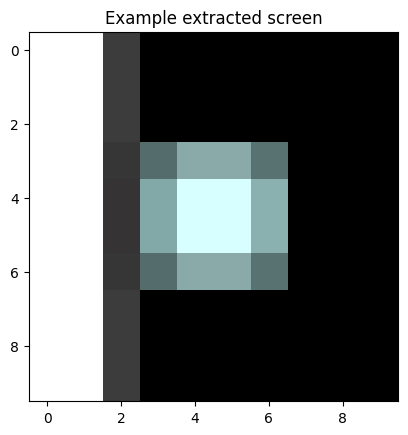

In [4]:
env.reset()

def get_screen():
    screen = env.render().transpose((2, 0, 1))  # transpose into torch order (CHW)
    _, screen_height, screen_width = screen.shape

    # full screen
    # screen = screen[:,:, 520:730]
    
    # area around agent
    # coordinaat van linkerbovenhoek rechthoek
    x_pixel_coo_agent = env._agent_location[0] * env.pix_square_size
    y_pixel_coo_agent = env._agent_location[1] * env.pix_square_size

    x_coo_right_up = x_pixel_coo_agent + 2 * env.pix_square_size
    x_coo_right_down = x_pixel_coo_agent - env.pix_square_size

    y_coo_left_down = y_pixel_coo_agent + 2 * env.pix_square_size
    y_coo_left_up = y_pixel_coo_agent - env.pix_square_size

    # left handed coordinate system
    screen = screen[:,y_coo_left_up:y_coo_left_down, x_coo_right_down:x_coo_right_up]

    

    # Convert to float, rescare, convert to torch tensor (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


plt.figure()
example_screen = get_screen()
# print(f"shape of screen: {screen.example_screen}")
plt.imshow(example_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 3, stride = 1):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [7]:
def select_action(state):
    return policy_net(state).max(1)[1].view(1, 1)

In [8]:
def testIters(policy_net, n_iters=60):
    
    for iteration in range(n_iters):

        wrapped = HumanRendering(env)

        # Initialize the environment and state
        env.reset()
        wrapped.reset()
        state = get_screen()

        for t in count():
            env.render()
            wrapped._render_frame()

            current_location = env._agent_location
            action = select_action(state)
            _, reward, done, _, _ = env.step(action.item())

            if not done:
                # 1 beeld
                next_state = get_screen()

            else:
                next_state = None

            # Move to the next state
            state = next_state

            # policy is stuck
            next_location = env._agent_location

            if np.array_equal(current_location, next_location):
                print("policy stuck \n")
                print("random actie kiezen")
                action =  torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)
                _, reward, done, _, _ = env.step(action.item())
            
            if done or ((t + 1) % 100 == 0):
                print("reset")
                break


    print('Complete')
    wrapped.render()
    wrapped.close()

    env.render()
    env.close()


In [16]:
if __name__ == "__main__":

    # Get screen size so that we can initialize layers correctly based on shape
    # returned from AI gym. 

    init_screen = get_screen()
    _, _, screen_height, screen_width = init_screen.shape

    # Get number of actions from gym action space
    n_actions = env.action_space.n
    print(n_actions)
    policy_net = torch.load('./model/higher_contrast_downscaled_1990.pkl')
    print('Model loaded')
    testIters(policy_net, n_iters=5)




4
Model loaded
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
policy stuck 

random actie kiezen
polic

KeyboardInterrupt: 